In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00038.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_01005.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00045.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00005.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00055.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00053.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00008.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00995.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_01019.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.applications.resnet50 as resnet50

In [7]:
IMG_SIZE = [100, 100]

In [8]:
TRAIN_DIR = '../input/covid-face-mask-detection-dataset/New Masks Dataset/Train'
TEST_DIR = '../input/covid-face-mask-detection-dataset/New Masks Dataset/Test'
VALID_DIR = '../input/covid-face-mask-detection-dataset/New Masks Dataset/Validation'

In [9]:
def get_image_paths(DIR, TERM):
    sample_imgs = []

    path = DIR + '/' + TERM

    for _,_,file in os.walk(path):
        
        sample_imgs.append(file)
    sample_imgs  = sample_imgs[0]
    
    return sample_imgs

In [10]:
img_list = get_image_paths(TRAIN_DIR, 'Mask')

In [11]:
img_paths = []
for img in img_list:
    path = os.path.join(TRAIN_DIR, 'Mask', img)
    img_paths.append(path)

(852, 480)


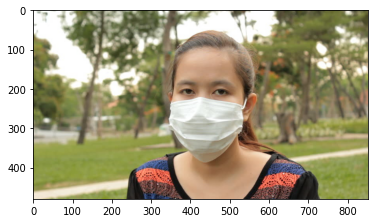

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

image = np.random.choice(img_paths)


import matplotlib.image as imping

def show_image():
    im = Image.open(image)
    print(im.size)
    img = imping.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

show_image()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
    width_shift_range=0.4,
    height_shift_range=0.4,
    zoom_range=0.2,
    featurewise_center=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [33]:
train_gen = gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.


In [34]:
vtgen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_gen = vtgen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

valid_gen = vtgen.flow_from_directory(
    directory=VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [16]:
resnet50_A = resnet50.ResNet50(input_shape=IMG_SIZE + [3], classes=2, weights=None)
resnet50_B = resnet50.ResNet50(include_top=False, input_shape=IMG_SIZE + [3], pooling='same')

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, BatchNormalization, MaxPool2D, PReLU, Dropout, Dense

class TopLayer(tf.keras.Model):
    
    def __init__(self):
        self.convBlock = convBlock()
        self.batchNormLayer = batchNormLayer()
    
    
    def convBlock(self):
        block = Sequential()
        block.add(Flatten())
        block.add(Dropout(0.5))
        block.add(Dense(50, activations='relu'))
        block.add(Dense(2, activations='softmax'))
        
        return block
    
    def batchNormLayer(self):
        bn = Sequential()
        bn.add(BatchNormalization())
        bn.add(PReLU())
        bn.add(Conv2D(32))
        bn.add(MaxPool2D())
        
        return bn
    
    def call(self, x):
       
        x = self.batchNormLayer(x)
        out = self.convBlock(x)
        
        return out   

In [18]:
resnet50_A.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model = tf.keras.Model(inputs=resnet50_A.input, outputs=resnet50_A.output)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy', 'mse']
)

In [21]:
epochs=100
batch_size = 32

In [22]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=300//batch_size,
    validation_steps=300//batch_size,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
9/9 [==============================] - 23s 2s/step - loss: 0.5693 - accuracy: 0.4187 - mse: 0.5693 - val_loss: 0.4965 - val_accuracy: 0.5035 - val_mse: 0.4965
Epoch 2/100
9/9 [==============================] - 9s 1s/step - loss: 0.4928 - accuracy: 0.5068 - mse: 0.4928 - val_loss: 0.4965 - val_accuracy: 0.5035 - val_mse: 0.4965
Epoch 3/100
9/9 [==============================] - 9s 1s/step - loss: 0.4419 - accuracy: 0.5360 - mse: 0.4419 - val_loss: 0.5000 - val_accuracy: 0.5000 - val_mse: 0.5000
Epoch 4/100
9/9 [==============================] - 8s 907ms/step - loss: 0.3751 - accuracy: 0.5707 - mse: 0.3751 - val_loss: 0.5035 - val_accuracy: 0.4965 - val_mse: 0.5035
Epoch 5/100
9/9 [==============================] - 8s 991ms/step - loss: 0.3537 - accuracy: 0.6416 - mse: 0.3537 - val_loss: 0.4931 - val_accuracy: 0.5069 - val_mse: 0.4931
Epoch 6/100
9/9 [==============================] - 8s 957ms/step - loss: 0.3866 - accuracy: 0.6110 - mse: 0.3866 - val_loss: 0.5149 - val_accur

In [23]:
def plot_graph(key):
    plt.plot(history.history[key], label=key)
    plt.plot(history.history['val_' + key], label='val_' + key)
    plt.legend()
    plt.show()

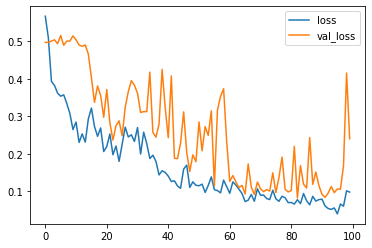

In [24]:
plot_graph('loss')

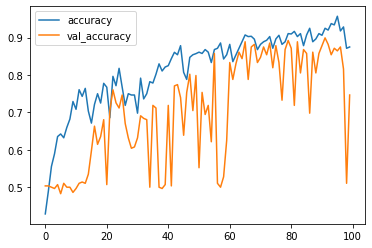

In [25]:
plot_graph('accuracy')

In [26]:
resnet50_B.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [27]:
model_body = tf.keras.Model(inputs=resnet50_B.input, outputs=resnet50_B.output)

In [28]:
x = BatchNormalization()(resnet50_B.output)
x = PReLU()(x)
x = Conv2D(32, kernel_size=(1, 1))(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
prediction = x

In [29]:
model = tf.keras.Model(inputs=resnet50_B.input, outputs=prediction)

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy', 'mse']
)

In [35]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=300//batch_size,
    validation_steps=300//batch_size,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 13s 1s/step - loss: 0.2496 - accuracy: 0.5312 - mse: 0.2496 - val_loss: 0.2500 - val_accuracy: 0.4965 - val_mse: 0.2500
Epoch 2/100
9/9 [==============================] - 8s 1s/step - loss: 0.2499 - accuracy: 0.4929 - mse: 0.2499 - val_loss: 0.2500 - val_accuracy: 0.5000 - val_mse: 0.2500
Epoch 3/100
9/9 [==============================] - 8s 981ms/step - loss: 0.2537 - accuracy: 0.4929 - mse: 0.2537 - val_loss: 0.4892 - val_accuracy: 0.4792 - val_mse: 0.4892
Epoch 4/100
9/9 [==============================] - 9s 1s/step - loss: 0.2576 - accuracy: 0.5382 - mse: 0.2576 - val_loss: 0.5000 - val_accuracy: 0.5000 - val_mse: 0.5000
Epoch 5/100
9/9 [==============================] - 8s 954ms/step - loss: 0.2597 - accuracy: 0.4857 - mse: 0.2597 - val_loss: 0.2499 - val_accuracy: 0.5139 - val_mse: 0.2499
Epoch 6/100
9/9 [==============================] - 8s 999ms/step - loss: 0.2709 - accuracy: 0.5393 - mse: 0.2709 - val_loss: 0.5104 - val_accur

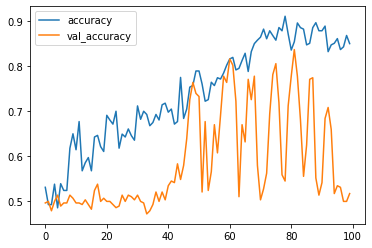

In [36]:
plot_graph('accuracy')

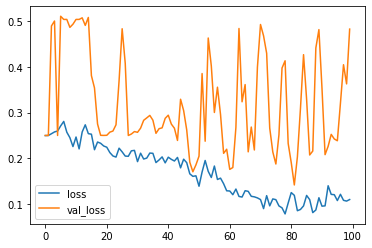

In [37]:
plot_graph('loss')

In [38]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
def get_confusion_matrix(N):
    print('Generating confusion matrix', N)
    
    predictions=[]
    targets=[]
    i = 0
    for x, y in test_gen:
        i += 1
        if i%50 == 0:
            print(i)
        
        p = model.predict(x)
        p = np.argmax(p, axis=1)
    
        y = np.argmax(y, axis=1)
        
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        
        if len(targets) >= N:
            break
     
    cm = tf.math.confusion_matrix(targets, predictions)
    #cm = plot_confusion_matrix(cm, ['Mask', 'NonMask'])
    return cm

In [58]:
for x, y in test_gen:
    p = model.predict(x)
    print(np.argmax(p, axis=1))
    print(y)
    break

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0.]


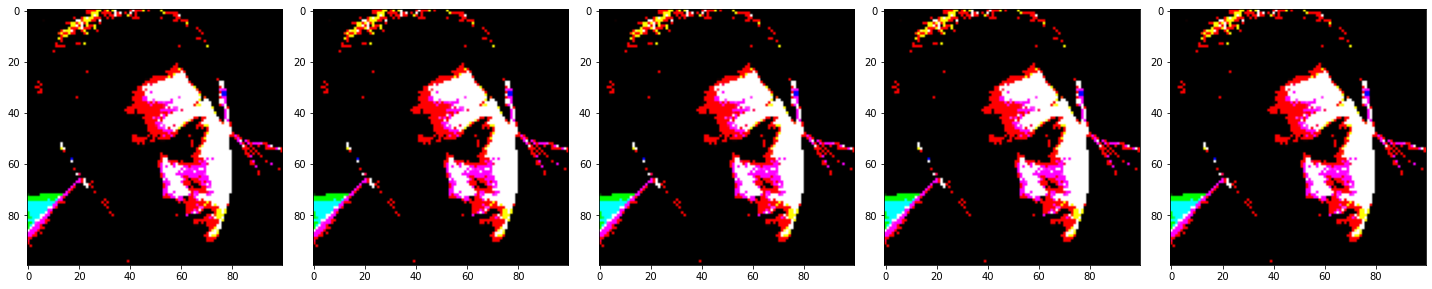

In [56]:
import random

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
images = [test_gen[0][0][0] for i in range(15, 20)]
plotImages(images)